# Packages

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_error, confusion_matrix
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors
import seaborn as sns


# Fingerprint Calculation

In [9]:
def get_maccs_fingerprint(smiles: str):
    if smiles == "-":
        # Return a list of zeros for the MACCS fingerprint (167 bits)
        return [0] * 167
    
    # Convert the SMILES string to an RDKit molecule object
    mol = Chem.MolFromSmiles(smiles)
    
    if mol is None:
        raise ValueError(f"Invalid SMILES string: {smiles}")
    
    # Generate the MACCS fingerprint
    maccs_fp = MACCSkeys.GenMACCSKeys(mol)
    
    # Convert the fingerprint to a list of bits (1 or 0) and ignore the first bit to get 166 bits
    #maccs_bits = list(maccs_fp)[1:]
    
    return list(maccs_fp)

def get_morgan_fingerprint(smiles: str):
    if smiles == "-":
        # Return a list of zeros for the Morgan fingerprint (default length 2048 bits)
        return [0] * 512
    
    # Convert the SMILES string to an RDKit molecule object
    mol = Chem.MolFromSmiles(smiles)
    
    if mol is None:
        raise ValueError(f"Invalid SMILES string: {smiles}")
    
    # Generate the Morgan fingerprint
    morgan_fp = AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=512)  # 2 is the radius of the fingerprint
    
    # Convert the fingerprint to a list of bits (1 or 0)
    morgan_bits = list(morgan_fp)
    
    return morgan_bits



def concatenate_fingerprints(smiles1: str, smiles2: str, smiles3: str):
    # Calculate MACCS fingerprints
    fp1 = get_maccs_fingerprint(smiles1)
    fp2 = get_maccs_fingerprint(smiles2)
    fp3 = get_maccs_fingerprint(smiles3)
    
    # Concatenate the fingerprints
    concatenated_fp = fp1 + fp2 + fp3
    
    return concatenated_fp



def process_dataframe(df):
    # Create an empty list to store concatenated fingerprints
    fingerprints = []

    # Iterate over the rows of the DataFrame
    for index, row in df.iterrows():
        smiles1 = row[1]  # Second column (index 1)
        smiles2 = row[2]  # Third column (index 2)
        smiles3 = row[4]  # Fifth column (index 4)
        
        # Get the concatenated fingerprint
        concatenated_fp = concatenate_fingerprints(smiles1, smiles2, smiles3)
        
        # Append the fingerprint to the list
        fingerprints.append(concatenated_fp)
    
    # Create a new DataFrame with the concatenated fingerprints
    fp_df = pd.DataFrame(fingerprints)
    
    return fp_df

In [10]:
df = pd.read_excel("C:\Research\SensorV\Dye Project\SMILES.xlsx", sheet_name="SMILES_V2", header=1)
df = df.drop(df.columns[:2], axis=1)

In [11]:
df

,Dye + Matrix,Dye SMILES,Dye Matrix SMILES,Targets/Non-Targets,Target/Non-Targets SMILES,Response,Unnamed: 8,Unnamed: 9
0,"5,10,15,20-tetraphenylporphyrinatozinc(II)",CO.CO.C1=CC=C(C=C1)[C+]2C3=C(C(=C([N-]3)[C+](C...,-,Ammonia,N,1,NaN,NaN
1,"5,10,15,20-tetraphenylporphyrinatozinc(II)",CO.CO.C1=CC=C(C=C1)[C+]2C3=C(C(=C([N-]3)[C+](C...,-,Dimethylamine,CNC,1,NaN,NaN
2,"5,10,15,20-tetraphenylporphyrinatozinc(II)",CO.CO.C1=CC=C(C=C1)[C+]2C3=C(C(=C([N-]3)[C+](C...,-,HCl,Cl,1,NaN,NaN
3,"5,10,15,20-tetraphenylporphyrinatozinc(II)",CO.CO.C1=CC=C(C=C1)[C+]2C3=C(C(=C([N-]3)[C+](C...,-,Methylamine,CN,1,NaN,NaN
4,"5,10,15,20-tetraphenylporphyrinatozinc(II)",CO.CO.C1=CC=C(C=C1)[C+]2C3=C(C(=C([N-]3)[C+](C...,-,Hydrazine,NN,1,NaN,NaN
...,...,...,...,...,...,...,...,...
1434,"3,4,5,6-Tetrabromophenolsulfonephthalein",C1=CC(=CC=C1C2(C3=C(C(=C(C(=C3Br)Br)Br)Br)S(=O...,-,Aspartame,COC(=O)C(CC1=CC=CC=C1)NC(=O)C(CC(=O)O)N,0,NaN,NaN
1435,"3,4,5,6-Tetrabromophenolsulfonephthalein",C1=CC(=CC=C1C2(C3=C(C(=C(C(=C3Br)Br)Br)Br)S(=O...,-,Asugryn,C1CCC(CC1)NS(=O)(=O)O.[Na+],0,NaN,NaN
1436,"3,4,5,6-Tetrabromophenolsulfonephthalein",C1=CC(=CC=C1C2(C3=C(C(=C(C(=C3Br)Br)Br)Br)S(=O...,-,Erythritol,C(C(C(CO)O)O)O,0,NaN,NaN
1437,"3,4,5,6-Tetrabromophenolsulfonephthalein",C1=CC(=CC=C1C2(C3=C(C(=C(C(=C3Br)Br)Br)Br)S(=O...,-,D-Glucose,C(C1C(C(C(C(O1)O)O)O)O)O,0,NaN,NaN


In [12]:
Fingerprints = process_dataframe(df)
Fingerprints['Response'] = df['Response']
X = Fingerprints.iloc[:, 0:-1].values
y = Fingerprints['Response']

In [13]:
Fingerprints

,0,1,2,3,4,5,6,7,8,9,...,492,493,494,495,496,497,498,499,500,Response
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1434,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,0
1435,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,0,1,1,1,1,0
1436,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1437,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,1,1,0,0


In [14]:
# Define the parameter grid to search through
param_grid = {
    'C': [70, 100],        # Regularization parameter
    'gamma': ['scale'],   # Kernel coefficient
    'kernel': ['poly'],  # Kernel type
    'degree' : [2, 3]
}

# Initialize SVC classifier
svc = SVC()

# Initialize Stratified K-Fold cross-validator
skf = StratifiedKFold(n_splits=8, shuffle=True)

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=skf, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X, y)

# Print the best parameters and best score
print("Best Parameters found:")
print(grid_search.best_params_)
print("Best Accuracy Score found:")
print(grid_search.best_score_)


Fitting 8 folds for each of 4 candidates, totalling 32 fits
Best Parameters found:
{'C': 70, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
Best Accuracy Score found:
0.7880392613283675


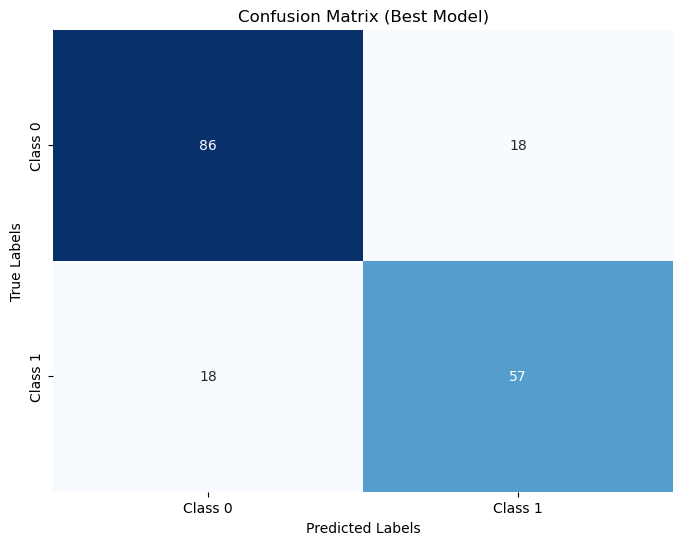

In [15]:
# Get the best model from GridSearchCV
best_svc = grid_search.best_estimator_

# Perform cross-validation with best model (to get confusion matrix for illustration)
conf_matrices = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Standardize the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train the best SVC model
    best_svc.fit(X_train_scaled, y_train)
    
    # Predict on test set
    y_test_pred = best_svc.predict(X_test_scaled)
    
    # Calculate confusion matrix for test set
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    conf_matrices.append(conf_matrix)

#Calculate average accuracy (optional)
avg_accuracy = np.mean(cross_val_score(best_svc, X, y, cv=skf, scoring='accuracy'))

# Plotting confusion matrix for the last fold (can be adjusted for any fold)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrices[-1], annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Best Model)')
plt.show()


In [16]:
print(avg_accuracy)

0.7755547796399751
